In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
class KissGPModel(gpytorch.GPModel):
    def __init__(self):
        super(KissGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        covar_module = RBFKernel(log_lengthscale_bounds=(-3, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(50, grid_bounds=[(0, 1)])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
model = KissGPModel()
model.condition(train_x, train_y)

KissGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [4]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

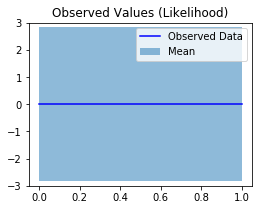

In [5]:
f = plot_model_and_predictions(model, plot_train_data=False)

In [6]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

/mnt/c/Users/Gardn/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 1/30 - Loss: 1147.993
Iter 2/30 - Loss: 1119.367
Iter 3/30 - Loss: 1087.448
Iter 4/30 - Loss: 1054.393
Iter 5/30 - Loss: 1029.911
Iter 6/30 - Loss: 996.839
Iter 7/30 - Loss: 973.208
Iter 8/30 - Loss: 945.654
Iter 9/30 - Loss: 918.948
Iter 10/30 - Loss: 888.757
Iter 11/30 - Loss: 845.761
Iter 12/30 - Loss: 797.042
Iter 13/30 - Loss: 725.736
Iter 14/30 - Loss: 656.113
Iter 15/30 - Loss: 566.394
Iter 16/30 - Loss: 473.614
Iter 17/30 - Loss: 389.344
Iter 18/30 - Loss: 313.409
Iter 19/30 - Loss: 243.983
Iter 20/30 - Loss: 184.007
Iter 21/30 - Loss: 127.836
Iter 22/30 - Loss: 85.887
Iter 23/30 - Loss: 39.087
Iter 24/30 - Loss: -0.425
Iter 25/30 - Loss: -31.016
Iter 26/30 - Loss: -60.919
Iter 27/30 - Loss: -90.473
Iter 28/30 - Loss: -112.585
Iter 29/30 - Loss: -126.887
Iter 30/30 - Loss: -131.714


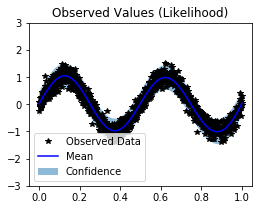

In [7]:
f = plot_model_and_predictions(model, plot_train_data=True)